In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from datetime import datetime
from operator import add
import pandas as pd
import string
import json
import re

In [2]:
spark_session = SparkSession.builder\
    .master("spark://192.168.2.133:7077")\
    .appName("New Analysis Plan")\
    .config("spark.dynamicAllocation.enabled", False)\
    .config("spark.driver.cores", 1)\
    .config("spark.driver.memory", "1g")\
    .config("spark.executor.cores", 2)\
    .config("spark.executor.memory", "2000m")\
    .config("spark.executor.instances", 4)\
    .getOrCreate()

spark_context = spark_session.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/24 00:58:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/24 00:58:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# PySpark Analysis

### 1. Read Data and Sample

In [3]:
comments = spark_context.textFile('hdfs://192.168.2.133:9000/user/root/reddit_data/RC_2012-01')

ratio = 1
seed = 81
comments_sampled = comments.sample(False, ratio, seed)

### 2. Maps String Into JSON

In [4]:
comments_json = comments_sampled.map(json.loads)
# comments_json.take(1)

### 3. Maps JSON Into (`time`, `body`) pairs

In [5]:
def unix_timestamp_converter(input_number):
    """
        Converts 1325376033 into 2012-12-21
    """
    return datetime.utcfromtimestamp(int(input_number)).strftime('%Y-%m-%d')

In [6]:
def timebody_mapper(json_object):
    """
        Converts JSON into a tuple of time and comment body
    """
    date_str = unix_timestamp_converter(json_object["created_utc"])
    body = json_object["body"]
    return (date_str, body)

In [7]:
timebody_pairs = comments_json.map(timebody_mapper)
# timebody_pairs.take(1)

### 4. Punctuation Removal

Works by substituting a punctuation with a space.

In [8]:
def punctuation_remover(input_tuple):
    date = input_tuple[0]
    new_body = re.sub(f"[{string.punctuation}]+", " ", input_tuple[1])
    return (date, new_body.lower())

In [9]:
punctuation_removed = timebody_pairs.map(punctuation_remover)
# punctuation_removed.take(1)

### 5. Tokenization

In [10]:
tokenized_rdd = punctuation_removed.map(lambda x: (x[0], x[1].split()))
# tokenized_rdd.take(1)

### 6. Sentence Filtering
Remove sentences that don't contain at least one of the given words

In [11]:
def sentence_filter(input_tuple):
    important_words = ["btc", "bitcoin", "cryptocurrency", "crypto"]
    return any([word in input_tuple[1] for word in important_words])

In [12]:
filtered_rdd = tokenized_rdd.filter(sentence_filter)
# print(filtered_rdd.count())
# print(filtered_rdd.take(1))

### 7. Calculate The Number of Comments

In [13]:
daily_comment_counts = filtered_rdd.map(lambda x: (x[0], 1)).reduceByKey(add)

In [14]:
daily_comment_counts_df = daily_comment_counts.toDF(["Date", "Comment_Count"]).toPandas().sort_values("Date").reset_index(drop=True)
daily_comment_counts_df['Date'] = pd.to_datetime(daily_comment_counts_df['Date'])
daily_comment_counts_df.head()

,Date,Comment_Count
0,2012-01-01,26
1,2012-01-02,86
2,2012-01-03,67
3,2012-01-04,78
4,2012-01-05,77


# Analysis in Pandas

### 1. Compare The Change in Number of Comments and Bitcoin Price Change

In [15]:
bitcoin_data = pd.read_csv('bitcoin_price.csv')
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
bitcoin_data.head()

,Date,Weighted_Price
0,2011-12-31,4.471603
1,2012-01-01,4.806667
2,2012-01-02,5.000000
3,2012-01-03,5.252500
4,2012-01-04,5.208159


In [16]:
merged_data = pd.merge(bitcoin_data, daily_comment_counts_df, on='Date', how='inner')
merged_data['Price_Change'] = abs(merged_data['Weighted_Price'].pct_change() * 100)
merged_data['Comment_Change'] = merged_data['Comment_Count'].diff()
merged_data = merged_data[merged_data['Price_Change'].notnull()].iloc[:,:].reset_index(drop=True)
merged_data

,Date,Weighted_Price,Comment_Count,Price_Change,Comment_Change
0,2012-01-02,5.000000,86,4.022191,60.0
1,2012-01-03,5.252500,67,5.050000,-19.0
2,2012-01-04,5.208159,78,0.844183,11.0
3,2012-01-05,6.284127,77,20.659273,-1.0
4,2012-01-06,6.438999,96,2.464493,19.0
5,2012-01-07,6.800000,83,5.606476,-13.0
6,2012-01-08,6.950000,52,2.205882,-31.0
7,2012-01-09,6.582770,84,5.283890,32.0
8,2012-01-10,6.603000,100,0.307323,16.0
9,2012-01-11,7.120685,78,7.840146,-22.0


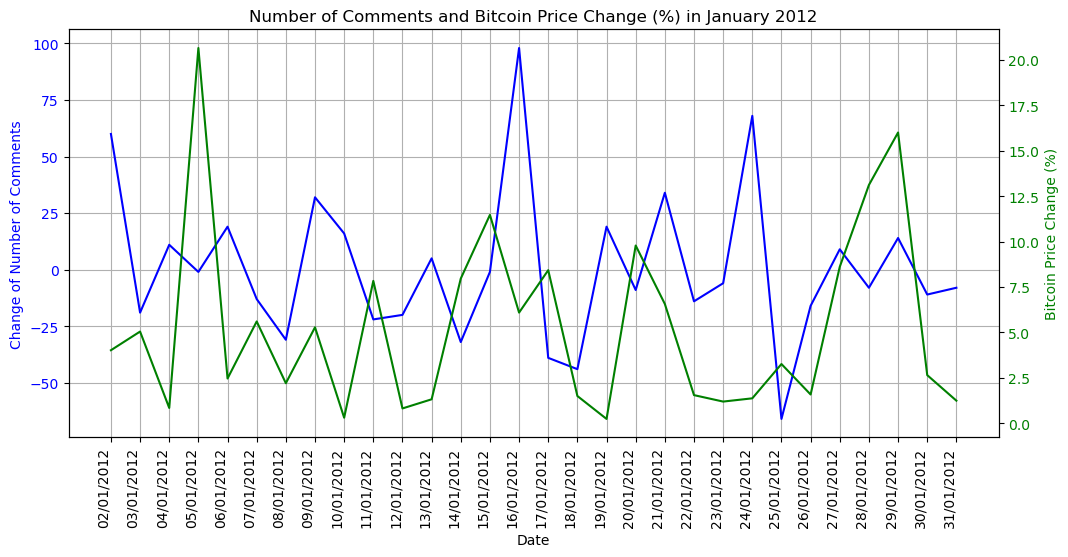

In [17]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data["Date"], merged_data['Comment_Change'], label='Change of Number of Comments', color='blue')
ax1.set_xlabel('Date')
ax1.set_xticks(merged_data["Date"])
labels = [i.strftime("%d/%m/%Y") for i in merged_data["Date"]]
ax1.set_xticklabels(labels)
ax1.set_ylabel('Change of Number of Comments', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid("Major")

ax2 = ax1.twinx()
ax2.plot(merged_data["Date"], merged_data['Price_Change'], label='Bitcoin Price Change (%)', color='green')
ax2.set_ylabel('Bitcoin Price Change (%)', color='green',rotation=90)
ax2.tick_params(axis='y', labelcolor='green')
fig.autofmt_xdate(rotation=90)
plt.title("Number of Comments and Bitcoin Price Change (%) in January 2012")

plt.show()

### 2. Autocorrelation Analysis

In [18]:
import pandas as pd
correlation_table = pd.DataFrame()
period_list = []
correlation_list = []

for lag_period in range(-10, 10):
    price_change = merged_data["Price_Change"]
    comment_change = merged_data["Comment_Change"].shift(lag_period)
    
    period_list.append(lag_period)
    correlation_list.append(comment_change.corr(price_change))

correlation_table["Lag_Period"] = period_list
correlation_table["Auto_Correlation"] = correlation_list
correlation_table

,Lag_Period,Auto_Correlation
0,-10,-0.026540
1,-9,-0.044415
2,-8,-0.014349
3,-7,0.094819
4,-6,-0.130820
5,-5,0.021354
6,-4,0.234394
7,-3,-0.282113
8,-2,-0.040278
9,-1,0.204328


The Correlation peaks when the lag period is 5. This indicates that the bitcoin price change correlates the most with the change of the number of reddit comments made 5 days ago.

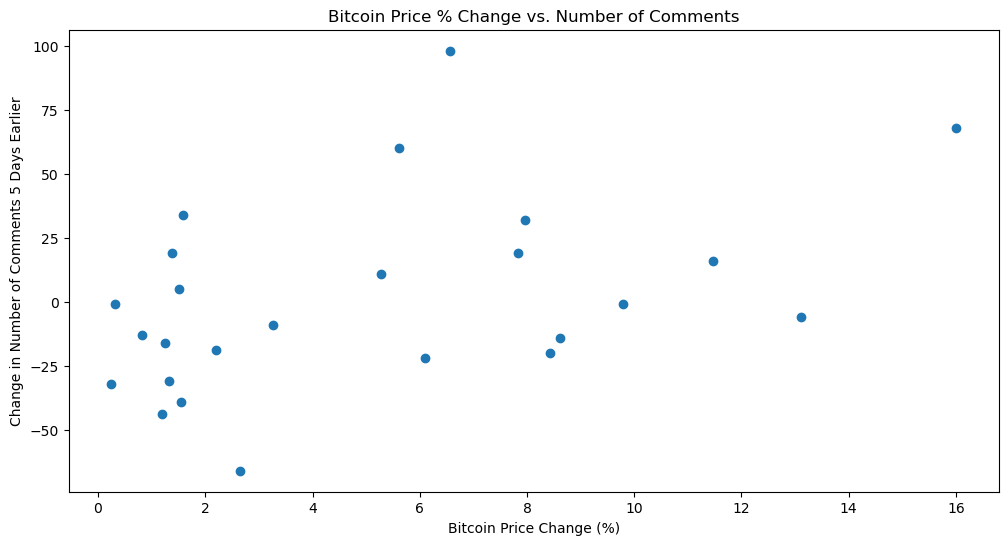

In [ ]:
lag_day = 5 # mutable integer

price_change = merged_data["Price_Change"]
comment_change = merged_data["Comment_Change"].shift(lag_day)

plt.figure(figsize=(12, 6))
plt.scatter(price_change, comment_change)
plt.xlabel("Bitcoin Price Change (%)")
plt.ylabel(f"Change in Number of Comments {lag_day} Days Earlier")
plt.title("Bitcoin Price % Change vs. Number of Comments")
plt.show()

In [20]:
spark_session.stop()